# Word Vector Functionalities Using GENSIM

**Some Background**  
When applying mathmatical models to free text, the purpose is typically deriving calculated conclusions such as:   
- Classifying the text as belonging to some category out of a set of given categories  
- Extracting key terms of some nature, ofter Names Entity Recognition  
- Extracting information from the text, sometime as an application of Question & Answering
- Summerizing the text  
- Translating the text  
- Deriving what the text communicates, often the sentiment of the writer  
- Etc.  

The expertise of the developer is in looking to optimize the process so to maximize the results.  
In order to do so there are several actions the developer can take:  
1. Improve the model  
2. Improve the data used for training the model    
3. Preprocess the data before appying it to train the model so to reduce the variability the model must train with  
4. Improve computation resources (more memory and faster computation)  

I'd like to stress the 3rd action.  
Preprocessing text can be applied so to reduce its variability which translates to dimensionality reduction of the feature space the model needs to train with.  
Another value that can be achieved through preprocessing is feature engineering that lends itself to a mathemtical relationship that mimics the preceptual relationship of the words it represents.  

That is the theme behin **word vectors**.  

## Preliminary Steps: Import, Install, and Load Files

**Import packages**

In [1]:
try:
    import requests
    from zipfile import ZipFile
    from tqdm import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    import os

except ImportError:
    sys.exit("""You are missing necessary Python libraries!
    Run the installation chunck.""")

import warnings; warnings.simplefilter('ignore')

plt.style.use('ggplot')

**Installation chunk** (uncomment necessary commands)

In [2]:
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# !pip install gensim
# !pip install requests
# !pip install zipfile

**Load the necessary files** (it'll download if necessary)

(for future commits: see if line `word_vectors = api.load("glove-wiki-gigaword-100")` from [here](https://radimrehurek.com/gensim/models/keyedvectors.html) does a better job for both this NB and maybe a Colab NB as well)

In [3]:
# This function downloads a file from "url" and presents a progress bar:
def download_file(url, glove_file):
    r = requests.get(url, stream=True, allow_redirects=True)
    total_size = int(r.headers.get('content-length'))
    initial_pos = 0
    with open(glove_file,'wb') as f: 
        with tqdm(total=total_size,
                  unit='B',
                  unit_scale=True,                      
                  desc=glove_file,initial=initial_pos, ascii=True) as pbar:
          for ch in r.iter_content(chunk_size=1024):                             
                  if ch:
                      f.write(ch) 
                      pbar.update(len(ch))

# Setting up paths:
folder_for_glove = os.getcwd() + os.sep + 'glove' + os.sep
glove_file = datapath(folder_for_glove + 'glove.6B.100d.txt')
url_for_zip = "https://nlp.stanford.edu/data/glove.6B.zip"
zip_file = datapath(folder_for_glove + url_for_zip.split('/')[-1])

# Check whether glove file exists in the envorironment, if not, download it:
does_glove_file_exist = os.path.exists(glove_file)
if does_glove_file_exist == False:
    # This means we'll need to download the zipped files and unzip them to the necessary folder:
    # Check folder exists:
    does_glove_folder_exist = os.path.exists(folder_for_glove)
    if does_glove_folder_exist == False:
        # Create a folder for glove:
        os.mkdir(folder_for_glove)
                 
    # Download zipped files:
    print("Downloading the zip file from:   " + url_for_zip)
    zip_file = download_file(url_for_zip, zip_file)

    # Extract files:
    with ZipFile(zip_file, 'r') as zipObj:
        print("Extracting glove files from the zipped file.")
        zipObj.extractall(folder_for_glove)
        print("Done extracting.")
else:
    print("Successfully located necessary glove file.")
        

Successfully located necessary glove file.


**Load necessary word embeddings**

In [4]:
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

(400000, 100)

## Playing with Word Embedding Functionalities

**Instantiated word vectors**

In [5]:
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [6]:
def analogy(similar=None, dissimilar=None, num_of_outputs=2):
    result = model.most_similar(positive=similar, negative=dissimilar)
    analogies = list(zip(*result))[0]
    print('\n'.join(analogies[0:num_of_outputs]))

In [7]:
analogy(['c++'], num_of_outputs=5)

compiler
fortran
compilers
javascript
objective-c


In [8]:
analogy('linkedin', num_of_outputs=5)

friendster
myspace
myspace.com
facebook
pinterest


In [9]:
analogy(dissimilar=['no'])

brett.clanton@chron.com
ryryryryryry


In [10]:
analogy(similar=['woman', 'king'], dissimilar=['man'], num_of_outputs=1)

queen


In [11]:
analogy(similar=['apple', 'fruit'], dissimilar=['red'])

pear
mango


In [12]:
analogy(similar=['long', 'highest'], dissimilar=['high'])

longest
ever


In [13]:
analogy(similar=['linkedin'], dissimilar=['work'])

pinterest
flipboard


In [14]:
analogy(similar=['metallica'], dissimilar=['loud'], num_of_outputs=1)

megadeth


In [15]:
analogy(similar=['fantastic', 'bad'], dissimilar=['good'])

terrible
awful


In [16]:
analogy(similar=['book', 'pool'], dissimilar=['water'])

essay
story


In [17]:
analogy(similar=['screen', 'person'], dissimilar=['head'])

user
viewer


In [18]:
analogy(similar=['exciting', 'regular'], dissimilar=['boring'])

starting
addition


In [19]:
analogy(similar=['light', 'night'], dissimilar=['dark'])

morning
afternoon


In [24]:
print(model.doesnt_match("ringo john paul yoko george ".split()))

yoko


Apply Principal Component Analysis via Singular Value Decomposition.  
It takes the vectors that represent the chosen words and generates a new set of vectors that spans the same vector space.  
Those vectors are **orthogonal unit vectors**, thus are more efficient in capturing the variability of the original set.  
We sort those vectors from most valuable to least valuable from the aspect of capturing the set's variability.  
We measure the set's variability by its variance.  
We measure a vector's capture of the variance by the magnitude of its corresponding eigenvalue.  
We thus take only the top 2 vectors so to portray the projection of the words' vector space in a 2 dimensional plot.  

*Credit to Stanford U. NLP course for this function*.

In [33]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(15,15))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

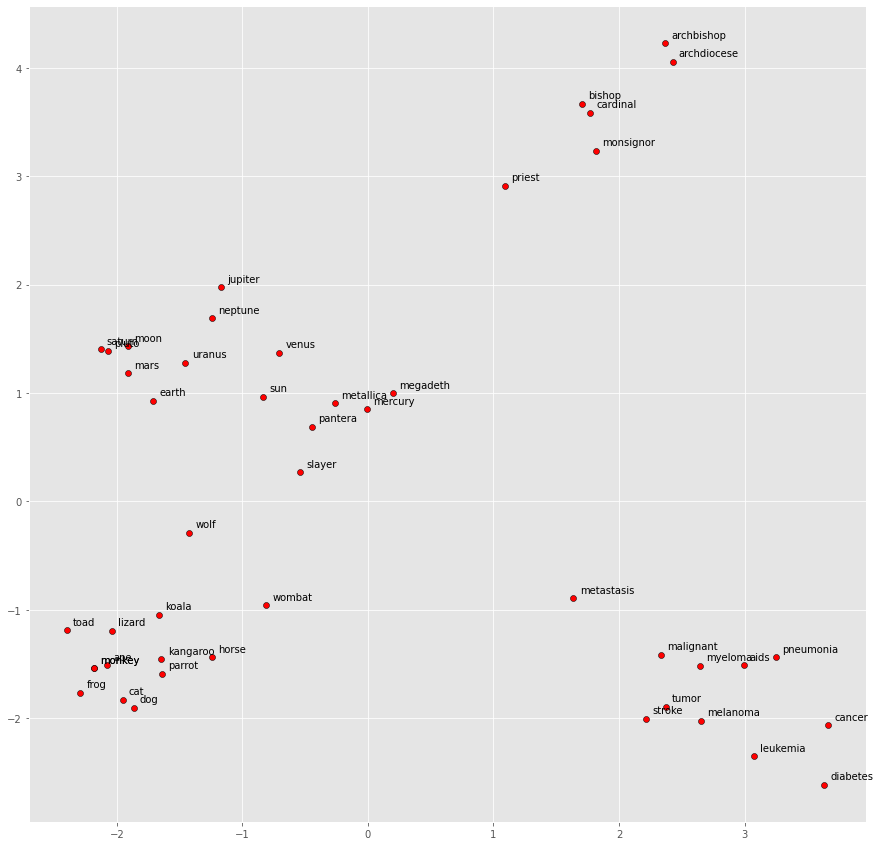

In [34]:
display_pca_scatterplot(model, 
                        ['metallica', 'megadeth', 'pantera', 'slayer',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'mercury', 'venus', 'earth', 'mars', 'jupiter', 
                         'saturn', 'uranus', 'neptune', 'pluto', 'sun', 'moon',
                        'cancer', 'pneumonia', 'diabetes', 'stroke', 'aids',
                        'leukemia', 'myeloma', 'melanoma', 'tumor', 'metastasis', 'malignant',
                        'archbishop', 'bishop', 'cardinal', 'monsignor', 'priest', 'archdiocese'])